# Product Range Analysis
## II. Customer RFM Segmentation
by: ***Dorothy Kunth***

## Table of Contents

- [Project Overview](#overview)
- [Customer RFM Segmentation using Percentile Ranking](#rfm_percentile)
- [Customer Segments Analysis](#cust_segments_analysis)
- [Customer RFM Segmentation using K-means Clustering](#rfm_kmeans)

<a id='overview'></a>
## Overview

You are given a sales transactions history data of an online store that sells household goods. Perform product range and customer segmentation analysis to help the stakeholders identify the top performing products, categories, and customers. 


### Business Problem
Based on the sales transactions data:
1. Identify the top performers: top customer, top product, and top category
2. Identify the customer segments based on RFM
3. Did higher-priced products contribute to higher sales than the lower-priced products?
4. Were sales higher during Christmas season (December) as compared to other months?


### Datasets and Attributes

The original dataset contains **541909** transaction records from **2018-11-29 to 2019-12-07**. It has 7 attributes:

- **InvoiceNo**: Invoice reference number uniquely assigned for each transaction. If the InvoiceNo starts with 'C', it indicates a cancellation
- **StockCode**: Product or item code uniquely assigned to each distinct product
- **Description**: Product or item name
- **Quantity**: The quantities for each product or item per transaction
- **InvoiceDate**: Invoice date and time, the day and time the transaction was generated by the system
- **UnitPrice**: Product price per unit
- **CustomerID**: Customer reference number uniquely assigned to each customer


### Project Scope
1. Data Preprocessing 
2. Exploratory Data Analysis
3. Customer Segmentation based on RFM Metrics (using percentile ranking and K-means clustering)
4. Product Categorization & Product Category Analysis
5. Statistical Hypotheses
6. Insights
7. Dashboard

<a id='rfm_percentile'></a>
### Customer RFM Segmentation using Percentile Ranking

To perform customer segmentation using RFM, calculate customer behavior metrics:

1. **Recency** - It measures how recent was each customer's last purchase. It is the number of days since the last transaction of the customer. The lower it is, the better, since every business wants its customers to be recent and active.
2. **Frequency** - It is a measure of how often customers buy from a company. It calculates the number of orders placed by a customer over a defined period of time.
3. **Monetary Value** - It measures how much has the customer spent within a given period. It is the total value that the customer spent with the company within a given period.

#### Prepare the data
- To calculate recency, frequency, and monetary value, we need the following variables: InvoiceDate, InvoiceNo, and LineTotal.
- To calculate recency, we need to have the most recent snapshot of data of today or yesterday, but since the data comes from 2018 and 2019, we will have to create a hypothetical snapshot date.

In [1]:
# Import libraries

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from datetime import timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the preprocessed dataset

sales_df = pd.read_pickle('../data/sales_df.pkl')
sales_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,LineTotal,Date,Period,Day,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850,15.30,2018-11-29,2018-11,Thursday,8
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850,20.34,2018-11-29,2018-11,Thursday,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850,22.00,2018-11-29,2018-11,Thursday,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850,20.34,2018-11-29,2018-11,Thursday,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850,20.34,2018-11-29,2018-11,Thursday,8


In [3]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 531172 entries, 0 to 541908
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    531172 non-null  object        
 1   StockCode    531172 non-null  object        
 2   Description  531172 non-null  object        
 3   Quantity     531172 non-null  int64         
 4   InvoiceDate  531172 non-null  datetime64[ns]
 5   UnitPrice    531172 non-null  float64       
 6   CustomerID   399656 non-null  object        
 7   LineTotal    531172 non-null  float64       
 8   Date         531172 non-null  object        
 9   Period       531172 non-null  period[M]     
 10  Day          531172 non-null  object        
 11  Hour         531172 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(6), period[M](1)
memory usage: 50.7+ MB


In [4]:
# Check the start and end dates of transactions

print(f"Transactions timeframe from {sales_df['InvoiceDate'].min()} to {sales_df['InvoiceDate'].max()}")

Transactions timeframe from 2018-11-29 08:26:00 to 2019-12-07 12:50:00


#### Create a hypothetical snapshot date

In [5]:
# Create hypothetical snapshot date

snapshot_date = sales_df['Date'].max() + timedelta(days = 1)
print(snapshot_date)

2019-12-08


A hypothetical snapshot date is created as the last invoice date plus 1 day since the data comes from 2018 and 2019.

#### Calculate RFM metrics

In [6]:
# Aggregate the data on a customer level

rfm = sales_df.groupby(['CustomerID']).agg({
    'Date': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'LineTotal': 'sum'})

# Rename columns
rfm.rename(columns = {
    'Date': 'Recency',
    'InvoiceNo': 'Frequency',
    'LineTotal': 'MonetaryValue'}, inplace = True)

rfm

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,2,0.00
12347,3,7,4310.00
12348,76,4,1437.24
12349,19,1,1457.55
12350,311,1,294.40
...,...,...,...
18280,278,1,180.60
18281,181,1,80.82
18282,8,3,176.60


**Note:**

``nunique`` aggregation is used instead of ``count`` for the frequency metric (number of unique invoices per customer, instead of number of invoice lines per customer)

In [7]:
rfm.describe()

,Recency,Frequency,MonetaryValue
count,4362.000000,4362.000000,4362.000000
mean,92.707703,4.994269,1894.882377
std,100.972922,9.083107,8266.070299
min,1.000000,1.000000,-1192.200000
25%,17.000000,1.000000,292.372500
50%,51.000000,3.000000,642.545000
75%,144.000000,5.000000,1584.745000
max,374.000000,242.000000,278778.020000


#### Group customers into tertiles based on each of the RFM metrics and assign labels to each one of them

In [8]:
# Calculate recency tertiles
recency_tertiles = pd.qcut(rfm['Recency'], q=3, labels = range(3, 0, -1))
rfm['R'] = recency_tertiles

# Calculate frequency tertiles
frequency_tertiles = pd.qcut(rfm['Frequency'], q=3, labels = range(1, 4))
rfm['F'] = frequency_tertiles

# Calculate monetary value tertiles
monetary_tertiles = pd.qcut(rfm['MonetaryValue'], q=3, labels = range(1, 4))
rfm['M'] = monetary_tertiles

rfm.sort_values('Recency')

,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
13426,1,11,3558.32,3,3,3
15910,1,8,1228.88,3,3,3
16954,1,9,2085.08,3,3,3
15804,1,19,3848.55,3,3,3
17001,1,11,3989.57,3,3,3
...,...,...,...,...,...,...
14142,374,1,311.81,1,1,1
17908,374,1,232.03,1,1,1
17968,374,1,265.10,1,1,1


**Note:**

- The 3-quantiles was used instead of 4-quantiles due to the distribution of frequency metric where frequency value of 1 comprise of 30% of the total customers.
- For the recency metric which calculates days since the last purchase, is better when it's low rather than high. Therefore, the values are reversed as lower recency is rated higher.

In [9]:
# Frequency value of 1 comprise 30% of the total customers

rfm['Frequency'].value_counts()[:1]

Frequency
1    1327
Name: count, dtype: int64

In [10]:
rfm['Frequency'].value_counts()[:1] / len(rfm)

Frequency
1    0.304218
Name: count, dtype: float64

In [11]:
# Preview the top 10 largest sizes for frequency metric 

frequency_values = rfm['Frequency'].value_counts()[:10].to_frame().reset_index()
frequency_values['percent_to_total'] = frequency_values['count'] / len(rfm)
frequency_values

,Frequency,count,percent_to_total
0,1,1327,0.304218
1,2,814,0.186612
2,3,490,0.112334
3,4,380,0.087116
4,5,284,0.065108
5,6,194,0.044475
6,7,153,0.035076
7,8,117,0.026823
8,9,79,0.018111
9,10,74,0.016965


#### Build RFM segments and calculate RFM scores

In [12]:
# Build RFM segments 
cols = ['R', 'F', 'M']
rfm['rfm_segment'] = rfm[cols].astype(str).apply(''.join, axis=1)

#Calculate RFM scores
rfm['rfm_score'] = rfm[cols].sum(axis=1)

rfm

,Recency,Frequency,MonetaryValue,R,F,M,rfm_segment,rfm_score
CustomerID,,,,,,,,
12346,326,2,0.00,1,1,1,111,3
12347,3,7,4310.00,3,3,3,333,9
12348,76,4,1437.24,2,2,3,223,7
12349,19,1,1457.55,3,1,3,313,7
12350,311,1,294.40,1,1,1,111,3
...,...,...,...,...,...,...,...,...
18280,278,1,180.60,1,1,1,111,3
18281,181,1,80.82,1,1,1,111,3
18282,8,3,176.60,3,2,1,321,6


#### Analyze RFM segments

In [13]:
# Count the number of unique segments

rfm['rfm_segment'].nunique()

27

In [14]:
# Review the sizes of each rfm_segment

rfm.groupby(['rfm_segment']).size().sort_values(ascending=False)

rfm_segment
111    742
333    714
211    367
233    318
112    307
212    284
311    210
322    191
222    180
122    129
312    125
332    112
223    104
323     95
232     83
133     68
121     55
123     49
113     47
132     43
213     41
221     40
321     27
313     18
131      9
331      3
231      1
dtype: int64

In [15]:
# View top 10 rows of the lowest rfm_segment '111'

rfm[rfm['rfm_segment'] == '111'][:10]

,Recency,Frequency,MonetaryValue,R,F,M,rfm_segment,rfm_score
CustomerID,,,,,,,,
12346,326,2,0.00,1,1,1,111,3
12350,311,1,294.40,1,1,1,111,3
12353,205,1,89.00,1,1,1,111,3
12361,288,1,174.90,1,1,1,111,3
12365,292,1,320.69,1,1,1,111,3
12373,312,1,324.60,1,1,1,111,3
12401,304,1,69.30,1,1,1,111,3
12402,324,1,195.60,1,1,1,111,3
12441,367,1,155.55,1,1,1,111,3


#### Calculate average RFM metrics and the count of customers per RFM score

In [16]:
# summary metrics per rfm_score

rfm.groupby(['rfm_score']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
rfm_score                                      
3           241.2       1.2         185.6   742
4           130.8       1.5         373.7   729
5            75.1       2.0         570.6   719
6            62.5       3.1        1016.6   466
7            48.2       4.5        1371.1   467
8            33.4       7.2        2438.3   525
9             9.6      15.5        7074.1   714

#### Segment customers based on RFM scores
- RFM score of 9: Top-performing customers
- RFM score of 7 and 8: Active customers
- RFM score of 5 and 6: Unsteady customers
- RFM score of 4: Customers at risk
- RFM score of 3: Inactive customers

In [17]:
# Use RFM scores to group customers into named segments

rfm.loc[rfm['rfm_score'] == 3, 'customer_segment'] = 'Inactive customers'
rfm.loc[rfm['rfm_score'] == 4, 'customer_segment'] = 'Customers at risk'
rfm.loc[rfm['rfm_score'].between(5, 6, inclusive='both'), 'customer_segment'] = 'Unsteady customers'
rfm.loc[rfm['rfm_score'].between(7, 8, inclusive='both'), 'customer_segment'] = 'Active customers'
rfm.loc[rfm['rfm_score'] == 9, 'customer_segment'] = 'Top-performing customers'

rfm

,Recency,Frequency,MonetaryValue,R,F,M,rfm_segment,rfm_score,customer_segment
CustomerID,,,,,,,,,
12346,326,2,0.00,1,1,1,111,3,Inactive customers
12347,3,7,4310.00,3,3,3,333,9,Top-performing customers
12348,76,4,1437.24,2,2,3,223,7,Active customers
12349,19,1,1457.55,3,1,3,313,7,Active customers
12350,311,1,294.40,1,1,1,111,3,Inactive customers
...,...,...,...,...,...,...,...,...,...
18280,278,1,180.60,1,1,1,111,3,Inactive customers
18281,181,1,80.82,1,1,1,111,3,Inactive customers
18282,8,3,176.60,3,2,1,321,6,Unsteady customers


In [18]:
# Verify that the named segments belong to the correct rfm scores

rfm.groupby(['rfm_score'])['customer_segment'].unique()

rfm_score
3          [Inactive customers]
4           [Customers at risk]
5          [Unsteady customers]
6          [Unsteady customers]
7            [Active customers]
8            [Active customers]
9    [Top-performing customers]
Name: customer_segment, dtype: object

#### Calculate the summary metrics per customer segment

In [19]:
segment = rfm.groupby(['customer_segment']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

segment.sort_values(by=('Recency', 'mean'))

Recency Frequency MonetaryValue      
                            mean      mean          mean count
customer_segment                                              
Top-performing customers     9.6      15.5        7074.1   714
Active customers            40.4       6.0        1935.9   992
Unsteady customers          70.1       2.4         746.0  1185
Customers at risk          130.8       1.5         373.7   729
Inactive customers         241.2       1.2         185.6   742

#### Visualize customers per segment

In [20]:
rfm = rfm.reset_index()

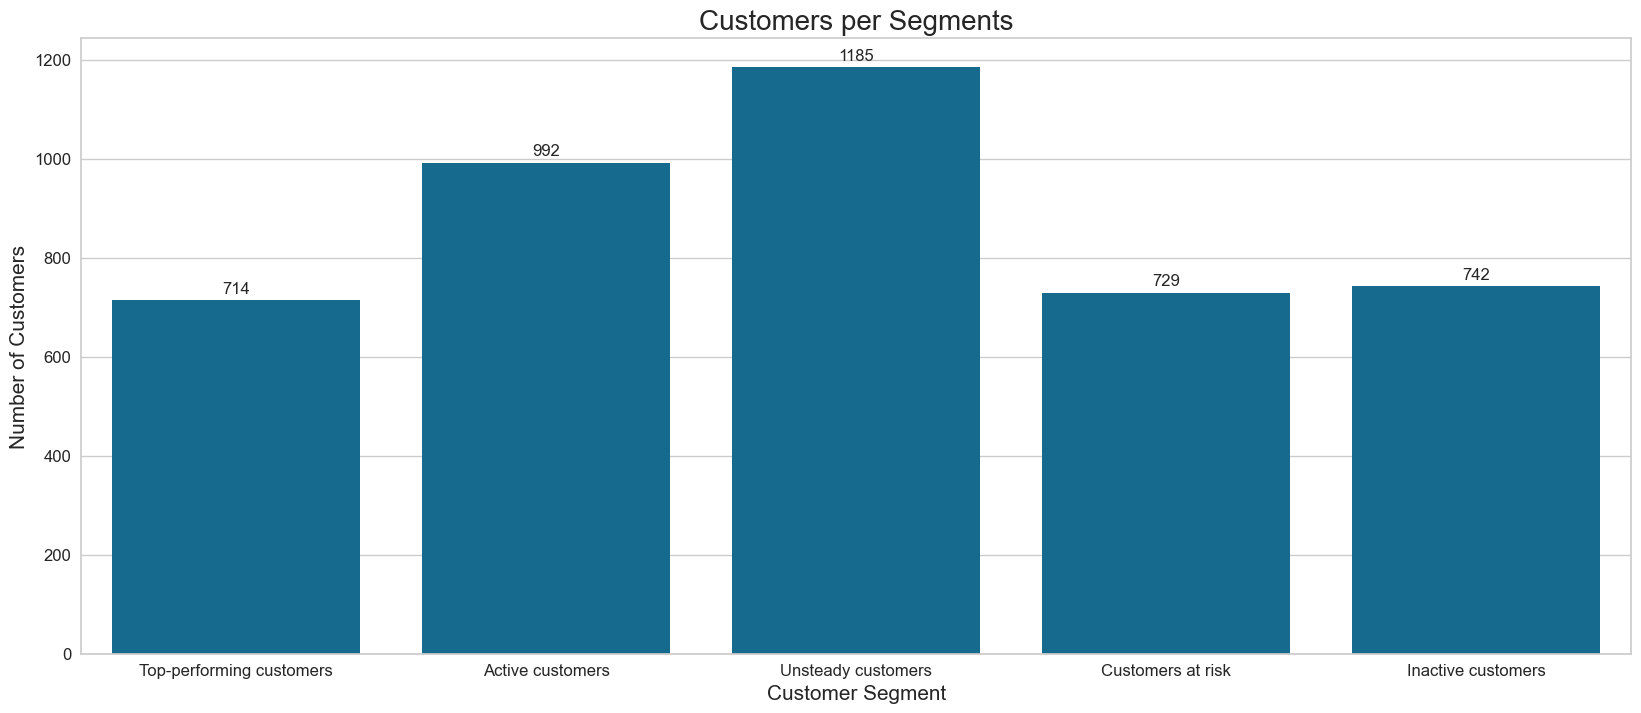

In [21]:
cust_segment = rfm.groupby(['customer_segment'])['CustomerID'].nunique()

plt.figure(figsize = [20, 8])
base_color = sns.color_palette()[0]
cat_order = ['Top-performing customers', 'Active customers', 'Unsteady customers', 'Customers at risk', 'Inactive customers']

ax = sns.barplot(x = cust_segment.index, y = cust_segment.values, color = base_color, order = cat_order)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax.bar_label(ax.containers[0], padding = 3)

plt.title('Customers per Segments', size=20)
plt.xlabel('Customer Segment', size = 15)
plt.ylabel('Number of Customers', size = 15)

plt.show();

#### Insights

In [22]:
top_and_active = rfm['customer_segment'].isin(['Top-performing customers', 'Active customers']).sum()/len(rfm)*100
unsteady = (rfm['customer_segment'] == 'Unsteady customers').sum()/len(rfm)*100
at_risk_and_inactive = rfm['customer_segment'].isin(['Customers at risk', 'Inactive customers']).sum()/len(rfm)*100

print('The proportion of top-performing and active customers is', "{:.2f}".format(top_and_active),'%')
print('The proportion of unsteady customers is', "{:.2f}".format(unsteady),'%')
print('The proportion of customers at risk and inactive customers is', "{:.2f}".format(at_risk_and_inactive),'%')

The proportion of top-performing and active customers is 39.11 %
The proportion of unsteady customers is 27.17 %
The proportion of customers at risk and inactive customers is 33.72 %


- The combined proportion of top and active customers is only 39.11% which means ***only 39.11% of customer base are making their purchases in an active manner.***
- Unsteady customer make up the 27% of customer base which means that about ***27% customers could either be active or inactive.***
- The combined proportion of customers at risk and inactive customers is 34%. ***34% of customer base need to be reactivated and encouraged to make more purchases and frequently.***

#### Marketing Campaign Recommendation

- **Inactive customers** - Send personalized emails containing special offers with discounted or free items to encourage them to order and be active.

- **Customers at risk** - This group of customers need attention as they made some purchases but it's been a long time since their last purchase. Send them personalized emails containing promotional items or free samples of products to encourage them to be more active.

- **Unsteady customers** - This group of customers are not consistently inactive nor active. Send them emails with discounted or promo items for every occasion including birthdays, mother's day, father's day, Christmas etc.

- **Active customers** - Create loyalty rewards program for this group where they can earn points for every purchase and convert these points into discount or voucher.

- **Top customers** - Send birthday and anniversary cards with discount vouchers. Create a referral program where they can get discounts on the first purchase of their referrals.

#### Create marketing campaign strategies based on customer segments

In [23]:
# Use customer segments to create marketing campaign strategies

rfm.loc[rfm['customer_segment'] == 'Top-performing customers', 'campaign_strategy'] = 'Send birthday and anniversary cards\
    with discount vouchers. Create a referral program where customers can get discounts on the first purchase of their \
    referrals.'
rfm.loc[rfm['customer_segment'] == 'Active customers', 'campaign_strategy'] = 'Create loyalty rewards program where \
    customers can earn points for every purchase and convert these points into discount or voucher.'
rfm.loc[rfm['customer_segment'] == 'Unsteady customers', 'campaign_strategy'] = "Send emails with discounted or \
    promotional items for every occasion, including birthdays, Mother's Day, Father's Day, and Christmas."
rfm.loc[rfm['customer_segment'] == 'Customers at risk', 'campaign_strategy'] = 'Send personalized emails containing \
    promotional items or free samples to encourage them to be more active.'
rfm.loc[rfm['customer_segment'] == 'Inactive customers', 'campaign_strategy'] = 'Send personalized emails containing special offers\
    with discounted or free items to encourage them to order and be active.'

rfm

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,rfm_segment,rfm_score,customer_segment,campaign_strategy
0,12346,326,2,0.00,1,1,1,111,3,Inactive customers,Send personalized emails containing special of...
1,12347,3,7,4310.00,3,3,3,333,9,Top-performing customers,Send birthday and anniversary cards with di...
2,12348,76,4,1437.24,2,2,3,223,7,Active customers,Create loyalty rewards program where custo...
3,12349,19,1,1457.55,3,1,3,313,7,Active customers,Create loyalty rewards program where custo...
4,12350,311,1,294.40,1,1,1,111,3,Inactive customers,Send personalized emails containing special of...
...,...,...,...,...,...,...,...,...,...,...,...
4357,18280,278,1,180.60,1,1,1,111,3,Inactive customers,Send personalized emails containing special of...
4358,18281,181,1,80.82,1,1,1,111,3,Inactive customers,Send personalized emails containing special of...
4359,18282,8,3,176.60,3,2,1,321,6,Unsteady customers,Send emails with discounted or promotional...
4360,18283,4,16,2039.58,3,3,3,333,9,Top-performing customers,Send birthday and anniversary cards with di...


#### Load the rfm dataframe as a csv file to local folder

In [24]:
# Load the rfm dataframe as a csv file to local folder

rfm.to_csv('../data/customer_rfm.csv', index=False)

#### Create a customer segment dataframe to only include customer id, customer segment, and campaign strategy variables

In [25]:
# Create df to only include customer id, customer segment and strategy

customer_segments = rfm[['CustomerID', 'customer_segment', 'campaign_strategy']]
customer_segments

,CustomerID,customer_segment,campaign_strategy
0,12346,Inactive customers,Send personalized emails containing special of...
1,12347,Top-performing customers,Send birthday and anniversary cards with di...
2,12348,Active customers,Create loyalty rewards program where custo...
3,12349,Active customers,Create loyalty rewards program where custo...
4,12350,Inactive customers,Send personalized emails containing special of...
...,...,...,...
4357,18280,Inactive customers,Send personalized emails containing special of...
4358,18281,Inactive customers,Send personalized emails containing special of...
4359,18282,Unsteady customers,Send emails with discounted or promotional...
4360,18283,Top-performing customers,Send birthday and anniversary cards with di...


#### Load the customer_segments dataframe to a csv in a local folder

In [26]:
# load the customer_segments df to a csv in local folder

customer_segments.to_csv('../data/customer_segments.csv', index=False)

<a id='cust_segments_analysis'></a>
### Customer Segments Analysis

In [27]:
# Create a dataframe to merge the preprocessed online trans dataframe and customer segments dataframe

sales_segmented = sales_df.merge(customer_segments, on = 'CustomerID', how ='left')
sales_segmented

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,LineTotal,Date,Period,Day,Hour,customer_segment,campaign_strategy
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850,15.30,2018-11-29,2018-11,Thursday,8,Active customers,Create loyalty rewards program where custo...
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850,20.34,2018-11-29,2018-11,Thursday,8,Active customers,Create loyalty rewards program where custo...
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850,22.00,2018-11-29,2018-11,Thursday,8,Active customers,Create loyalty rewards program where custo...
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850,20.34,2018-11-29,2018-11,Thursday,8,Active customers,Create loyalty rewards program where custo...
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850,20.34,2018-11-29,2018-11,Thursday,8,Active customers,Create loyalty rewards program where custo...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531167,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2019-12-07 12:50:00,0.85,12680,10.20,2019-12-07,2019-12,Saturday,12,Active customers,Create loyalty rewards program where custo...
531168,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2019-12-07 12:50:00,2.10,12680,12.60,2019-12-07,2019-12,Saturday,12,Active customers,Create loyalty rewards program where custo...
531169,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2019-12-07 12:50:00,4.15,12680,16.60,2019-12-07,2019-12,Saturday,12,Active customers,Create loyalty rewards program where custo...
531170,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2019-12-07 12:50:00,4.15,12680,16.60,2019-12-07,2019-12,Saturday,12,Active customers,Create loyalty rewards program where custo...


#### How much revenue were generated by each customer segment?

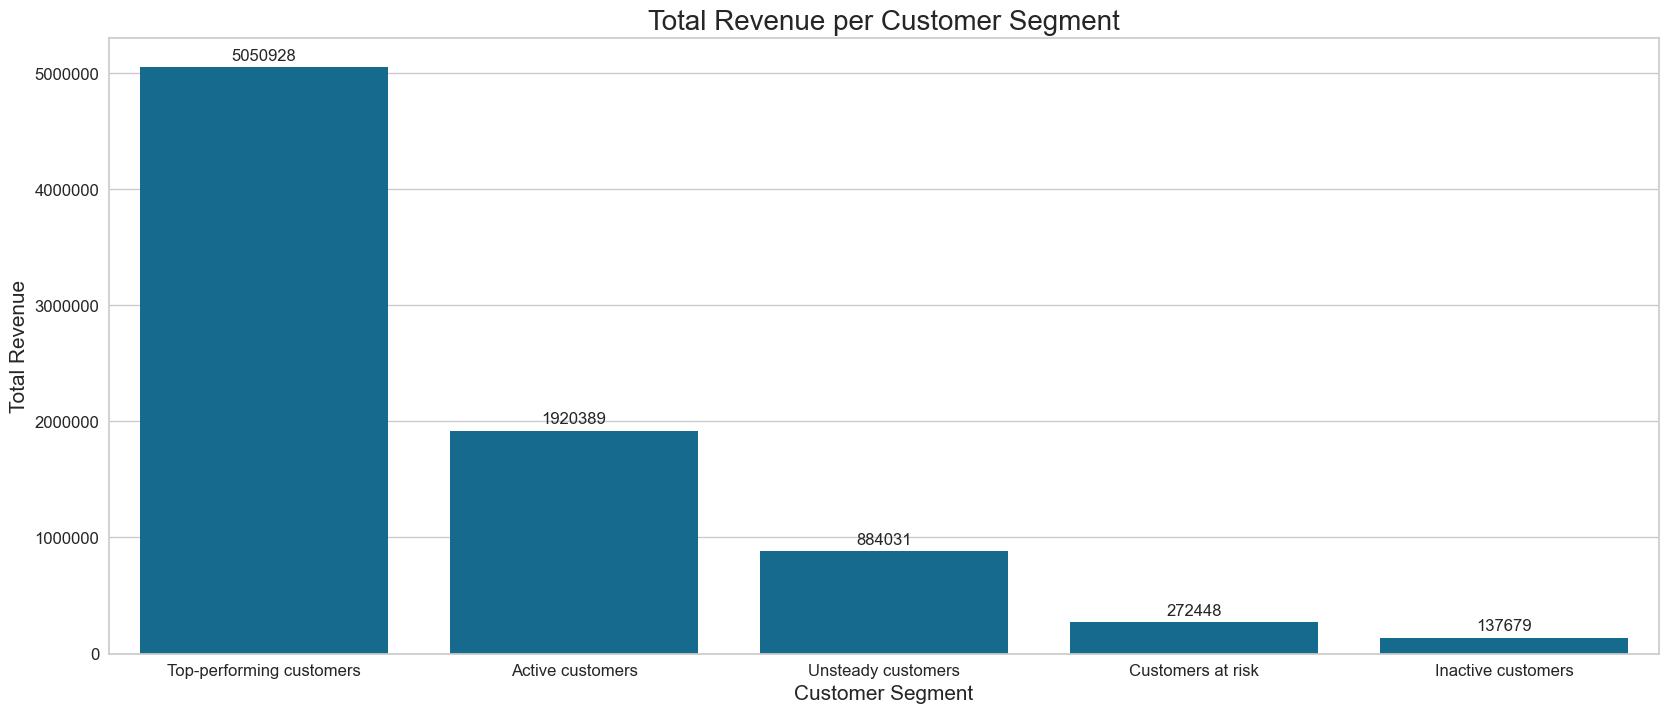

In [28]:
segment_rev = sales_segmented.groupby(['customer_segment'])['LineTotal'].sum()

plt.figure(figsize = [20, 8])
base_color = sns.color_palette()[0]

# Order to plot the categorical variables in
order = ['Top-performing customers', 'Active customers', 'Unsteady customers', 'Customers at risk', 'Inactive customers']

ax = sns.barplot(x = segment_rev.index, y = segment_rev.values, color = base_color, order = order)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax.bar_label(ax.containers[0], padding = 3, fmt = '%d') # annotates bar plots with labels without scientific notation)

plt.title('Total Revenue per Customer Segment', size = 20)
plt.xlabel('Customer Segment', size = 15)
plt.ylabel('Total Revenue', size = 15)
yticks = [0, 1000000, 2000000, 3000000, 4000000, 5000000]
ax.set_yticklabels(yticks)
plt.show;

#### Which segment of customers generates the most revenue each month?

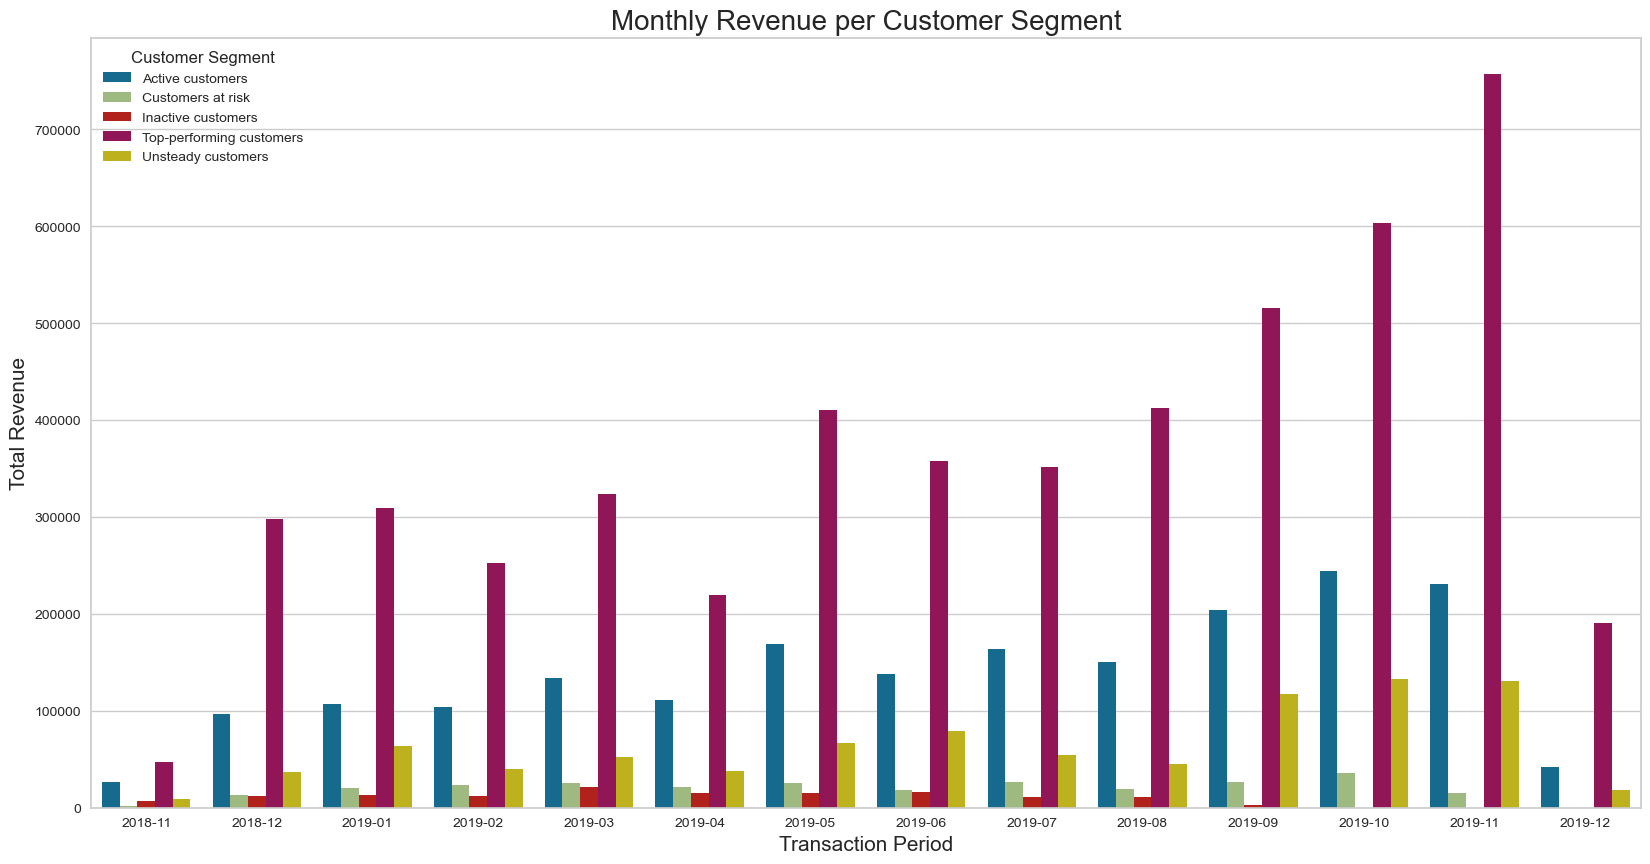

In [29]:
monthly_rev = sales_segmented.groupby(['Period', 'customer_segment'])['LineTotal'].sum().reset_index()

plt.figure(figsize = [20, 10])
ax = sns.barplot(data= monthly_rev, x = 'Period', y = 'LineTotal', 
               hue = 'customer_segment', errwidth=0)
plt.title("Monthly Revenue per Customer Segment", size=20)
plt.xlabel("Transaction Period", size=15)
plt.ylabel("Total Revenue", size=15)
ax.legend(loc = 2, ncol = 1, title = 'Customer Segment')
plt.show();

- Top-performing customers consistently generated the most revenue per month
- Inactive customers have not generated any sales revenue for the last 3 months.
- During the last month, customers at risk did not generate sales revenue

#### In which period did the top-perfoming customers exceed the overall average monthly revenue?

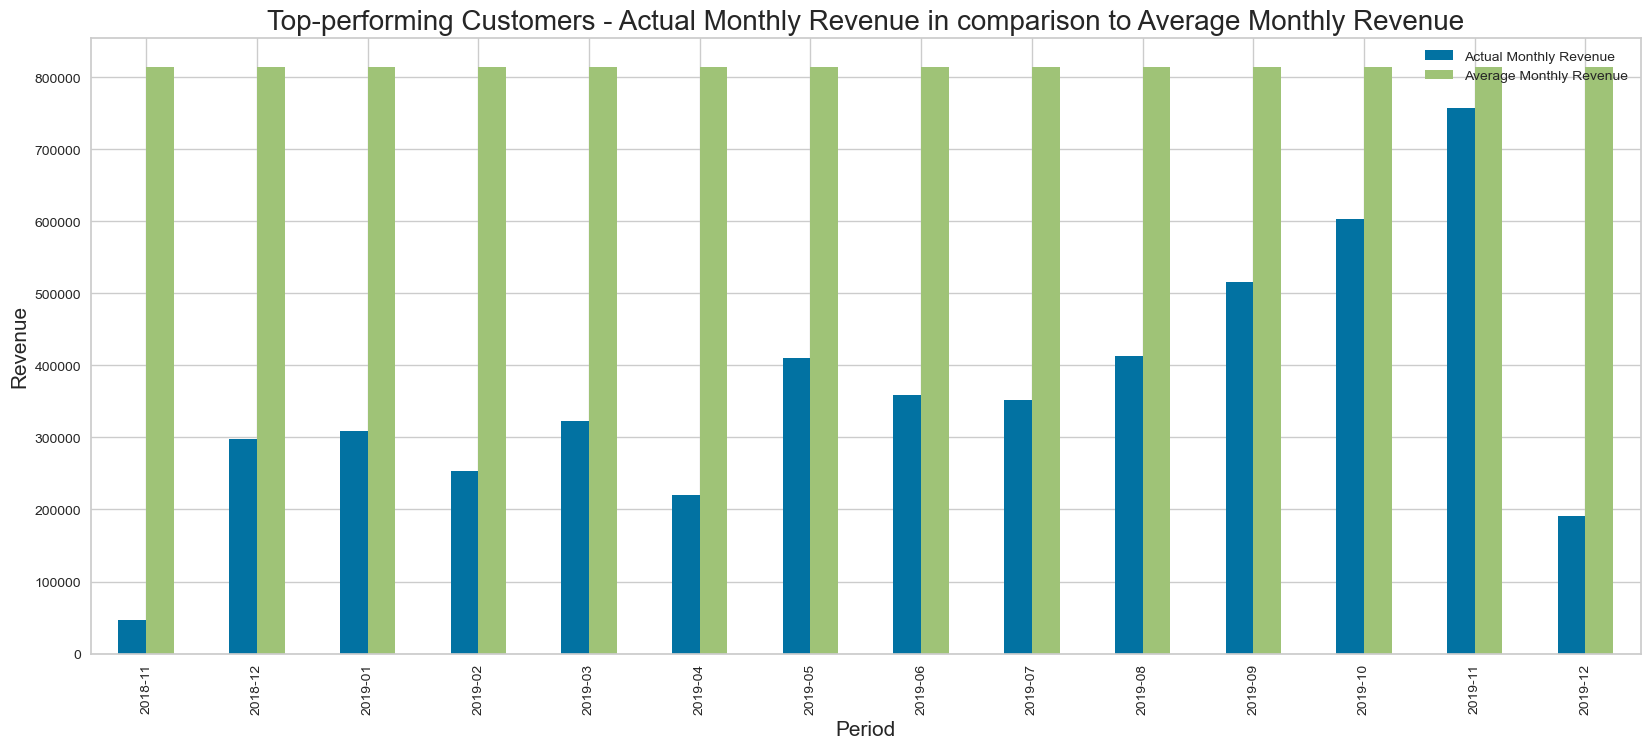

In [30]:
top_cust = sales_segmented[sales_segmented['customer_segment'] == 'Top-performing customers']
top_cust_monthly = top_cust.groupby(['Period'])['LineTotal'].sum().reset_index()
top_cust_monthly['average_revenue'] = round(sales_segmented['LineTotal'].sum()/12, 2)

top_cust_monthly.plot(kind = 'bar', x = 'Period', figsize = [20, 8])
plt.title('Top-performing Customers - Actual Monthly Revenue in comparison to Average Monthly Revenue', fontsize = 20)
plt.xlabel('Period', fontsize = 15)
plt.ylabel('Revenue', fontsize = 15)
plt.legend(['Actual Monthly Revenue', 'Average Monthly Revenue'])
plt.show()

- The top-performing customers never exceeded overall monthly average revenue.

#### How much of the total orders are placed by top-performing customers?

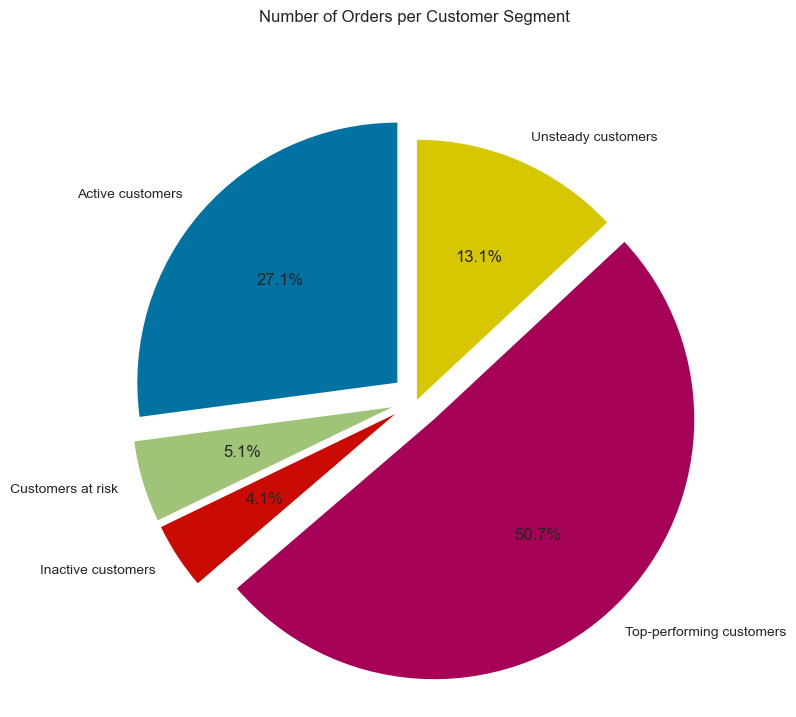

In [31]:
num_orders = sales_segmented.groupby(['customer_segment'])['InvoiceNo'].nunique()
num_orders.plot(kind = 'pie', labels = num_orders.index, autopct = '%1.1f%%', figsize = (20, 8), startangle = 90,
               explode=[0.1, 0.1, 0.1, 0.1, 0])
plt.axis('square')
plt.title ('Number of Orders per Customer Segment', pad = 50)
plt.ylabel('')
plt.show()

- 50% of the total orders are placed by top-performing customers.

#### Which segment of customers generates the most revenue per day of the week?

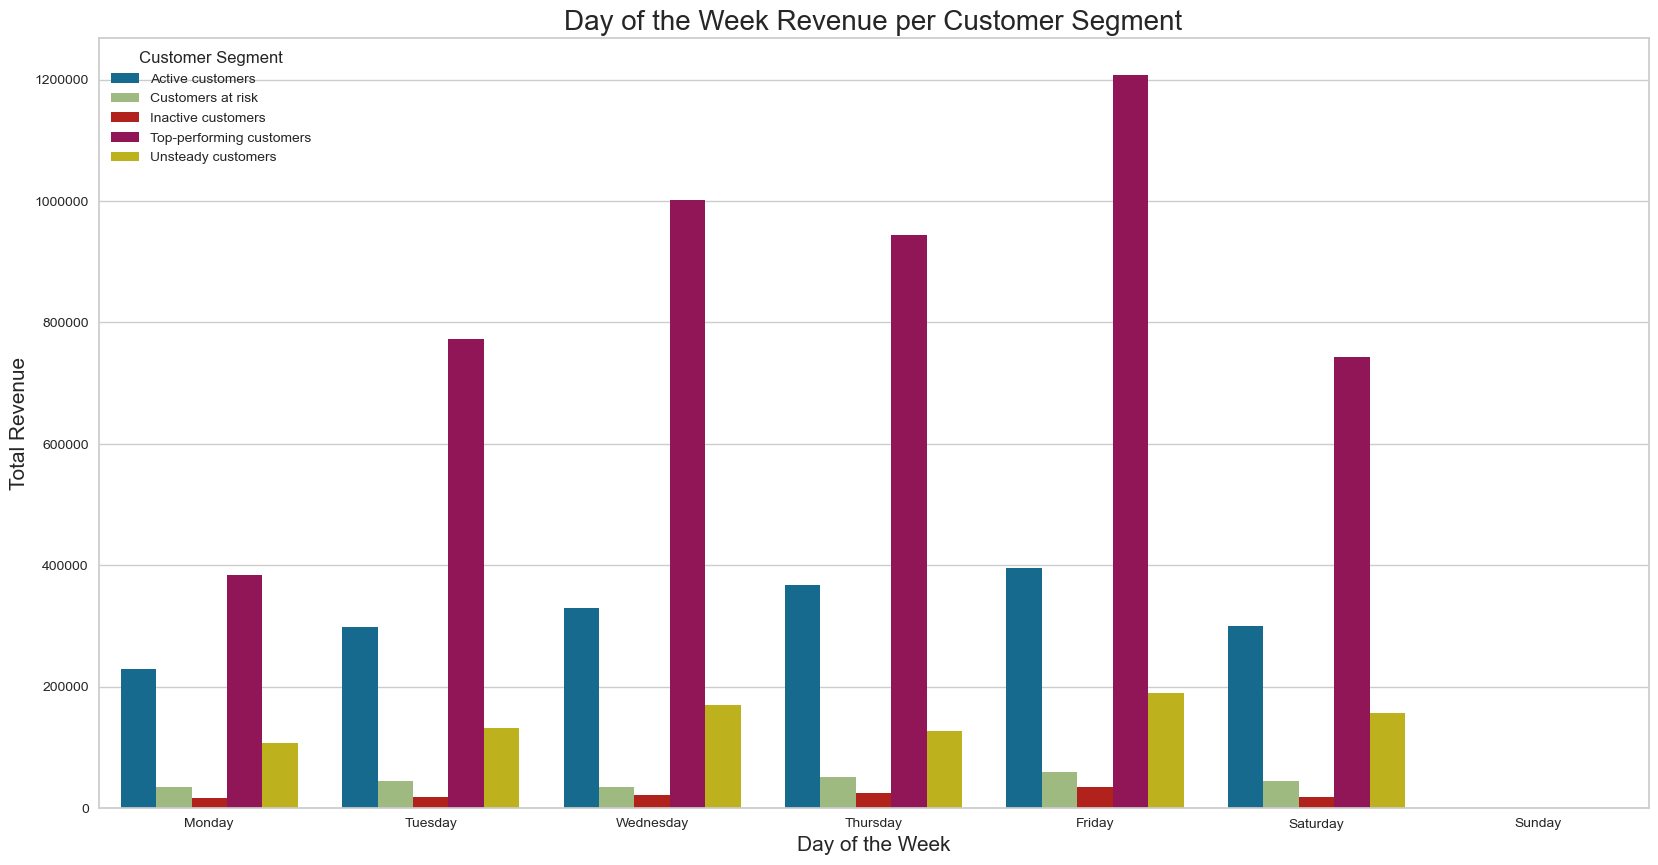

In [32]:
day_rev = sales_segmented.groupby(['Day', 'customer_segment'])['LineTotal'].sum().reset_index()

plt.figure(figsize = [20, 10])

# Order to plot the categorical variables in
cat_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


ax = sns.barplot(data= day_rev, x = 'Day', y = 'LineTotal', hue = 'customer_segment', 
                 errwidth=0, order = cat_order)
plt.title("Day of the Week Revenue per Customer Segment", size=20)
plt.xlabel("Day of the Week", size=15)
plt.ylabel("Total Revenue", size=15)
ax.legend(loc = 2, ncol = 1, title = 'Customer Segment')
yticks = [0, 200000, 400000, 600000, 800000, 1000000, 1200000]
ax.set_yticklabels(yticks)
plt.show();

- The top-performing customers consistently generated the highest revenue per day of the week.

<a id='rfm_kmeans'></a>
### Customer RFM Segmentation using K-means Clustering

#### Key K-means Assumptions:
- Numerical variables only
- Data has no significant number of outliers or noise
- All variables have symmetrical distribution
- Each variable has equal average value and equal variance

In [33]:
# Load the data

rfm = pd.read_csv('../data/customer_rfm.csv')
rfm

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,rfm_segment,rfm_score,customer_segment,campaign_strategy
0,12346,326,2,0.00,1,1,1,111,3,Inactive customers,Send personalized emails containing special of...
1,12347,3,7,4310.00,3,3,3,333,9,Top-performing customers,Send birthday and anniversary cards with di...
2,12348,76,4,1437.24,2,2,3,223,7,Active customers,Create loyalty rewards program where custo...
3,12349,19,1,1457.55,3,1,3,313,7,Active customers,Create loyalty rewards program where custo...
4,12350,311,1,294.40,1,1,1,111,3,Inactive customers,Send personalized emails containing special of...
...,...,...,...,...,...,...,...,...,...,...,...
4357,18280,278,1,180.60,1,1,1,111,3,Inactive customers,Send personalized emails containing special of...
4358,18281,181,1,80.82,1,1,1,111,3,Inactive customers,Send personalized emails containing special of...
4359,18282,8,3,176.60,3,2,1,321,6,Unsteady customers,Send emails with discounted or promotional...
4360,18283,4,16,2039.58,3,3,3,333,9,Top-performing customers,Send birthday and anniversary cards with di...


In [34]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4362 entries, 0 to 4361
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         4362 non-null   int64  
 1   Recency            4362 non-null   int64  
 2   Frequency          4362 non-null   int64  
 3   MonetaryValue      4362 non-null   float64
 4   R                  4362 non-null   int64  
 5   F                  4362 non-null   int64  
 6   M                  4362 non-null   int64  
 7   rfm_segment        4362 non-null   int64  
 8   rfm_score          4362 non-null   int64  
 9   customer_segment   4362 non-null   object 
 10  campaign_strategy  4362 non-null   object 
dtypes: float64(1), int64(8), object(2)
memory usage: 375.0+ KB


In [35]:
# Create a dataframe to only include only the recency, frequency, and monetary value columns

rfm_km = rfm[['Recency', 'Frequency', 'MonetaryValue']]
rfm_km

,Recency,Frequency,MonetaryValue
0,326,2,0.00
1,3,7,4310.00
2,76,4,1437.24
3,19,1,1457.55
4,311,1,294.40
...,...,...,...
4357,278,1,180.60
4358,181,1,80.82
4359,8,3,176.60
4360,4,16,2039.58


In [36]:
rfm_km.describe()

,Recency,Frequency,MonetaryValue
count,4362.000000,4362.000000,4362.000000
mean,92.707703,4.994269,1894.882377
std,100.972922,9.083107,8266.070299
min,1.000000,1.000000,-1192.200000
25%,17.000000,1.000000,292.372500
50%,51.000000,3.000000,642.545000
75%,144.000000,5.000000,1584.745000
max,374.000000,242.000000,278778.020000


#### Check for Outliers

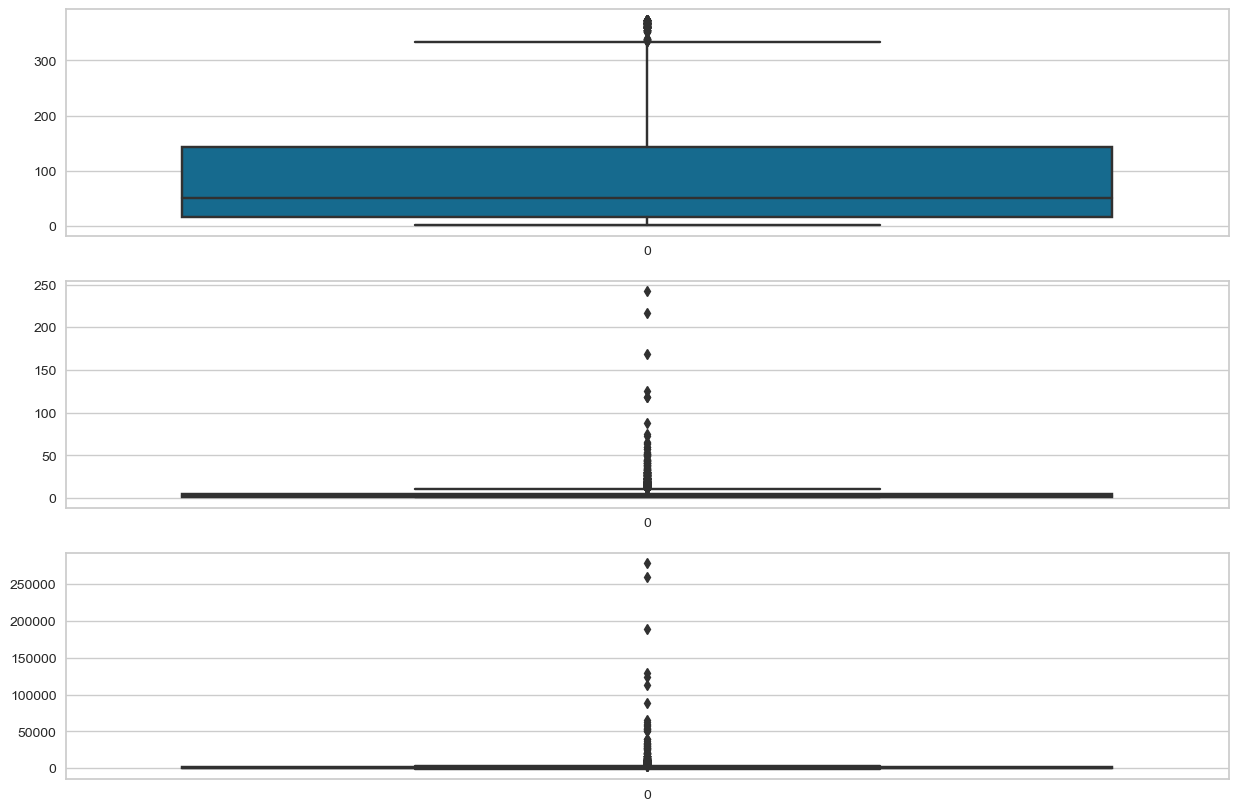

In [37]:
# Create boxplot for each variable
plt.figure(figsize=[15,10])

#plot distribution of recency
plt.subplot(3, 1, 1)
sns.boxplot(rfm_km['Recency'])

#plot distribution of frequency
plt.subplot(3, 1, 2)
sns.boxplot(rfm_km['Frequency'])

#plot distribution of monetary value
plt.subplot(3, 1, 3)
sns.boxplot(rfm_km['MonetaryValue'])

plt.show();

- Boxplots show that each of the recency, frequency, and monetary value variables has outliers.

#### Identify Outliers
- Identify outliers using z-scores with a z-score >= 3

In [38]:
# Identify outliers

z_scores = stats.zscore(rfm_km)
abs_z_scores = np.abs(z_scores)
filtered_data = (abs_z_scores < 3).all(axis = 1)

In [39]:
# Check how many data points are outliers (False)

filtered_data.value_counts()

True     4298
False      64
Name: count, dtype: int64

In [40]:
# Percentage of outliers to total customers

(filtered_data.value_counts()[1]/len(filtered_data)) * 100

1.4672168729940394

- The outliers make up 1% of the total number of customers. I assumed that this won't have a significant impact on clustering, therefore it is not necessary to exclude them.

#### Visualize the distribution of each variable

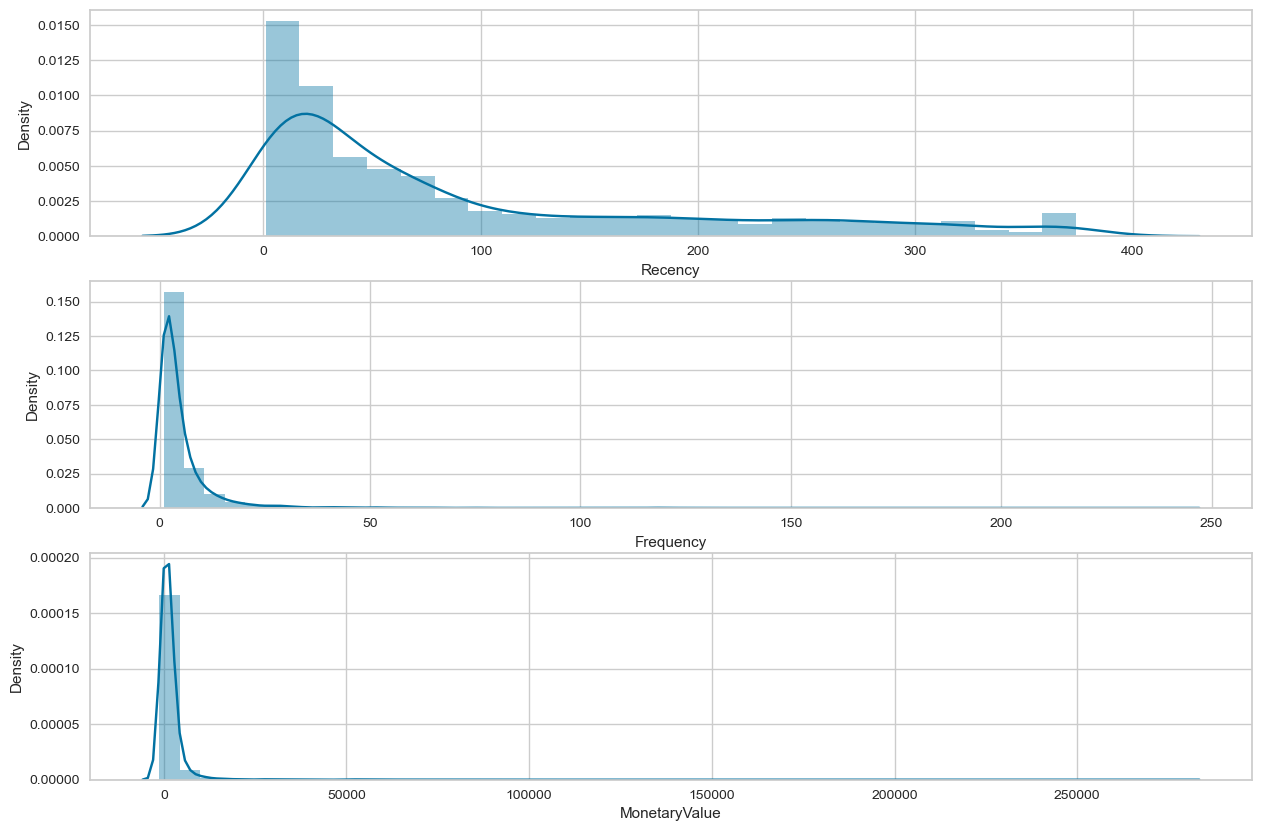

In [41]:
# plot RFM distributions
plt.figure(figsize=[15,10])

#plot distribution of recency
plt.subplot(3, 1, 1)
sns.distplot(rfm_km['Recency'])

#plot distribution of frequency
plt.subplot(3, 1, 2)
sns.distplot(rfm_km['Frequency'])

#plot distribution of monetary value
plt.subplot(3, 1, 3)
sns.distplot(rfm_km['MonetaryValue'])

plt.show();

- The distribution of recency, frequency and monetary value metrics are all right skewed.

#### Apply logarithmic transformation to unskew the data

- Logarithmic transformation works only on positive values
- Manage negative values by adding the absolute value of the lowest negative value to each observation, then add a small constant like 1 to force the variables to be strictly positive

In [42]:
# Check for negative values

rfm_km.describe()

,Recency,Frequency,MonetaryValue
count,4362.000000,4362.000000,4362.000000
mean,92.707703,4.994269,1894.882377
std,100.972922,9.083107,8266.070299
min,1.000000,1.000000,-1192.200000
25%,17.000000,1.000000,292.372500
50%,51.000000,3.000000,642.545000
75%,144.000000,5.000000,1584.745000
max,374.000000,242.000000,278778.020000


In [43]:
print('The number of observations with negative values in MonetaryValue variable:', (rfm_km['MonetaryValue']<0).sum())

The number of observations with negative values in MonetaryValue variable: 30


In [44]:
# Deal with negative values
# Add the absolute value of the lowest negative value to each monetary values then add 1

rfm_km['MonetaryValue'] += (1192.20 +1)
rfm_km.describe()

,Recency,Frequency,MonetaryValue
count,4362.000000,4362.000000,4362.000000
mean,92.707703,4.994269,3088.082377
std,100.972922,9.083107,8266.070299
min,1.000000,1.000000,1.000000
25%,17.000000,1.000000,1485.572500
50%,51.000000,3.000000,1835.745000
75%,144.000000,5.000000,2777.945000
max,374.000000,242.000000,279971.220000


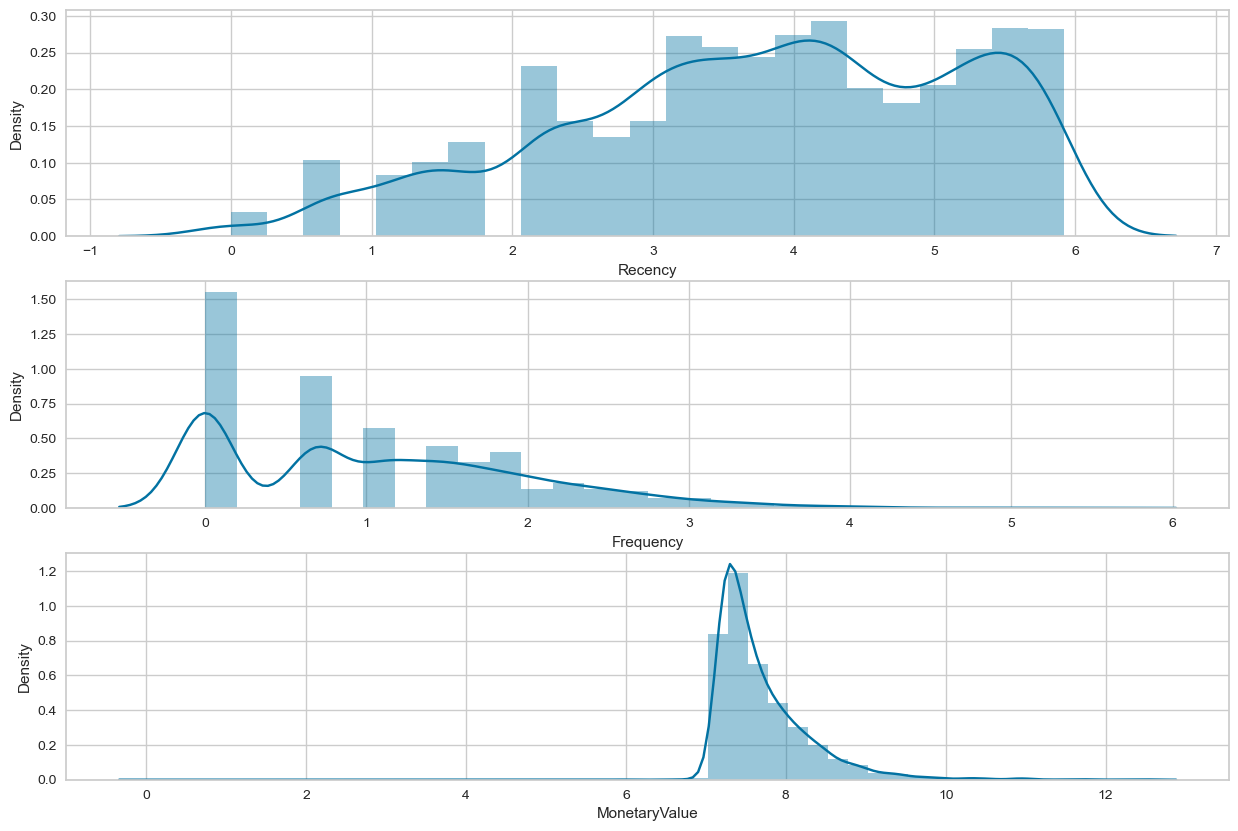

In [45]:
# Unskew the data
rfm_km_log = np.log(rfm_km)

# plot transfomed RFM distributions
plt.figure(figsize=[15,10])

#plot distribution of recency
plt.subplot(3, 1, 1)
sns.distplot(rfm_km_log['Recency'])

#plot distribution of frequency
plt.subplot(3, 1, 2)
sns.distplot(rfm_km_log['Frequency'])

#plot distribution of monetary value
plt.subplot(3, 1, 3)
sns.distplot(rfm_km_log['MonetaryValue'])

plt.show();

- The distributions are not perfectly symmetrical, there are still some skewness but not very skewed compared to the original distribtuion.

#### Center and scale the variables

As K-means works well on variables with the same mean and variance:

- Centering can be done by manually subtracting the average value from each observation
- Scaling can be done by dividing each observation by standard deviation of each
- Alternatively, a built-in function StandardScaler() from scikit-learn library can be used to normalize the variables

In [46]:
rfm_km_log.describe()

,Recency,Frequency,MonetaryValue
count,4362.000000,4362.000000,4362.000000
mean,3.769242,1.060374,7.700134
std,1.412458,0.949695,0.602286
min,0.000000,0.000000,0.000000
25%,2.833213,0.000000,7.303555
50%,3.931826,1.098612,7.515206
75%,4.969813,1.609438,7.929467
max,5.924256,5.488938,12.542442


In [47]:
# Initialize StandardScaler and fit

scaler = StandardScaler()
scaler.fit(rfm_km_log)

# Transform and store the scaled data for clustering
rfm_km_normalized = scaler.transform(rfm_km_log)
rfm_km_normalized = pd.DataFrame(data=rfm_km_normalized, index=rfm_km_log.index, columns=rfm_km_log.columns)
rfm_km_normalized.describe().round(2)

,Recency,Frequency,MonetaryValue
count,4362.00,4362.00,4362.00
mean,0.00,0.00,0.00
std,1.00,1.00,1.00
min,-2.67,-1.12,-12.79
25%,-0.66,-1.12,-0.66
50%,0.12,0.04,-0.31
75%,0.85,0.58,0.38
max,1.53,4.66,8.04


- Now each variable has an average of zero and standard deviation of 1.

#### Build elbow criterion plot

- Use elbow criterion method to choose the number of clusters
- The elbow criterion method plots the sum of squared errors (SSE) for each number of segments which is basically the sum of squared distances from each data point to their cluster center.
- Identify an elbow in the plot - which represents the optimal number of clusters.

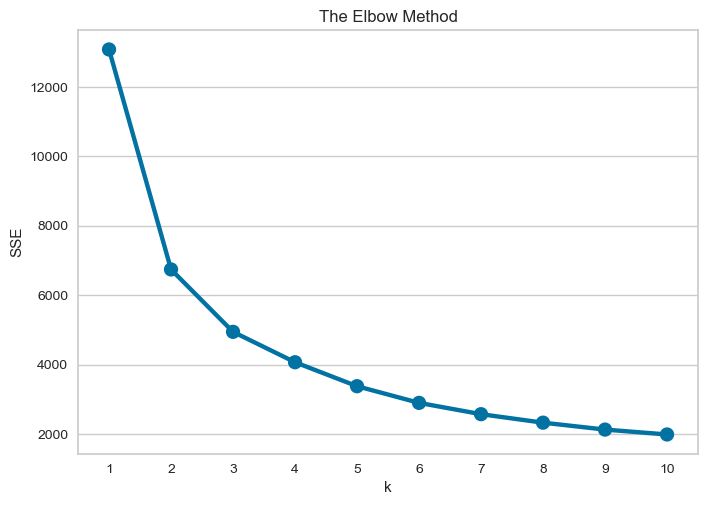

In [48]:
# Fit KMeans and calculate sum of squared errors for each k

# empty dictionary for sum squared of errors
sse = {} 

# run for loop over different number of clusters between 1 and 10 to build kmeans segmentation on rfm_km_normalized
for k in range(1, 11): 
    
    #initialize K-means with k clusters and fit it
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm_km_normalized)
    
    # assign sum of squared distance to k element of the sse dictionary
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

# plot SSE for each k
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show();

- The elbow criterion plot shows point 2 is where we identify the largest angle, suggesting 2 clusters.
- Identifying the number of clusters based on where the elbow is formed is not a hard rule. It is recommended to use experimental approach to choose the optimal number of clusters by calculating the average RFM and compare the results to identify the number of clusters that is most useful and provides the most insight.
- For the purpose of this segmentation, we will build segments based on 2, 3, and 4 clusters and compare the outputs.

#### Silhouette Analysis

- The silhouette score is a measure of how close each sample in one cluster is to the samples in the neighboring clusters.
- It ranges from -1 to 1, and a higher value indicates that samples are well clustered.

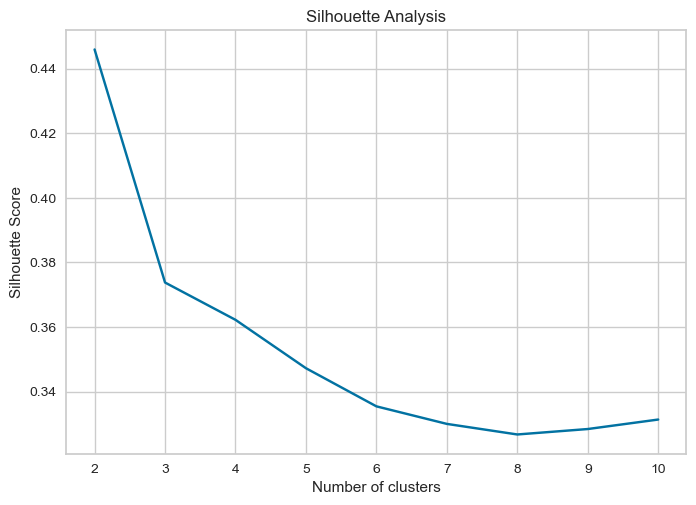

In [49]:
ave_sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k, random_state = 0).fit(rfm_km_normalized)
  labels = kmeans.labels_
  ave_sil.append(silhouette_score(rfm_km_normalized, labels, metric = 'euclidean'))

plt.plot(range(2, 11), ave_sil)
plt.title('Silhouette Analysis')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

- According to the Silhouette Analysis, 2-cluster is the optimal number.

#### Silhouette plot of a model with 2-cluster

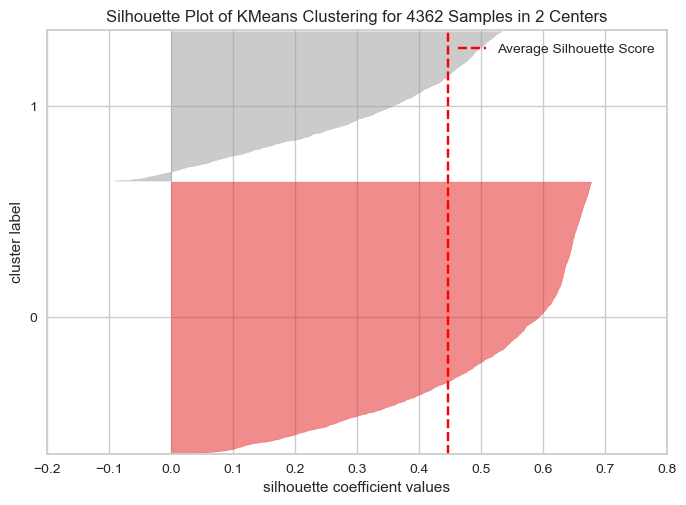

# of clusters: 2
Silhouette score 0.4459681094811304


In [50]:
silh = SilhouetteVisualizer(KMeans(2, random_state = 0))
silh.fit(rfm_km_normalized)
silh.poof()
print("# of clusters:", silh.n_clusters_)
print("Silhouette score", silh.silhouette_score_)

#### Silhouette plot of a model with 3-cluster

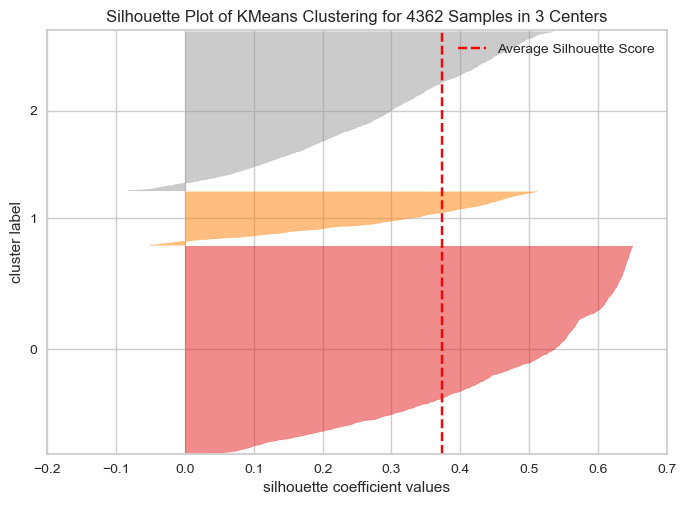

# of clusters: 3
Silhouette score 0.3737842578259356


In [51]:
silh = SilhouetteVisualizer(KMeans(3, random_state = 0))
silh.fit(rfm_km_normalized)
silh.poof()
print("# of clusters:", silh.n_clusters_)
print("Silhouette score", silh.silhouette_score_)

#### Run K-means using 2 clusters

In [52]:
kmeans = KMeans(n_clusters = 2, random_state = 1)

# Fit k-means clustering on the data
kmeans.fit(rfm_km_normalized)

#extract cluster labels
cluster_labels_2 = kmeans.labels_

In [53]:
# Create a cluster label column in the rfm_km data

rfm_km = rfm_km.assign(cluster2 = cluster_labels_2)

# Group data by cluster and calculate average rfm values and segment sizes per cluster
rfm_km.groupby(['cluster2']).agg({   
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(2).sort_values(by=('Recency', 'mean'))

Recency Frequency MonetaryValue      
            mean      mean          mean count
cluster2                                      
0          23.59     10.49       5627.25  1549
1         130.77      1.97       1689.87  2813

Based on 2-cluster solution:

- Cluster 1 could be profiled as wholesalers with average recency of 23 days, average frequency of 10 times, and average spend of 5600.
- Cluster 0 could be profiled as individual customers with average recency of 131 days, average frequency of 2 time(s) and average spend of 1600.

#### Run K-means using 3 clusters

In [54]:
kmeans = KMeans(n_clusters = 3, random_state = 1)

# Fit k-means clustering on the data
kmeans.fit(rfm_km_normalized)

#extract cluster labels
cluster_labels_3 = kmeans.labels_

In [55]:
# Create a cluster label column in the rfm_km data

rfm_km = rfm_km.assign(cluster3 = cluster_labels_3)

# Group data by cluster and calculate average rfm values and segment sizes per cluster
rfm_km.groupby(['cluster3']).agg({   
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(2).sort_values(by=('Recency', 'mean'))

Recency Frequency MonetaryValue      
            mean      mean          mean count
cluster3                                      
0          15.58     18.73      10639.68   555
2          33.76      4.79       2480.97  1654
1         157.87      1.61       1607.84  2153

Based on 3-cluster solution:

- Cluster 0 could be profiled as active customers with average recency of 15 days, average frequency of 18 times, and average spend of 10000.
- Cluster 2 could be profiled as unsteady customers with average recency of 33 days, average frequency of 4 times and average spend of 2400.
- Cluster 1 could be profiled as inactive customers with average recency of 157 days, average frequency of 1 time(s) and average spend of 1600.

#### Run K-means using 4 clusters

In [56]:
kmeans = KMeans(n_clusters = 4, random_state = 1)

# Fit k-means clustering on the data
kmeans.fit(rfm_km_normalized)

#extract cluster labels
cluster_labels_4 = kmeans.labels_

In [57]:
# Create a cluster label column in the rfm_km data

rfm_km = rfm_km.assign(cluster4 = cluster_labels_4)

# Group data by cluster and calculate average rfm values and segment sizes per cluster
rfm_km.groupby(['cluster4']).agg({   
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(2).sort_values(by=('Recency', 'mean'))

Recency Frequency MonetaryValue      
            mean      mean          mean count
cluster4                                      
3          11.51     19.16      10949.09   520
1          15.25      2.90       1877.26   901
2          60.47      5.98       2929.49  1067
0         170.84      1.51       1579.25  1874

Based on 4-cluster solution:

- Cluster 3 could be profiled as top customers:
    - most current, most frequent and highest spend
- Cluster 1 could be profiled as emerging customers:
    - 2nd most current but 3rd most frequent and 3rd highest spend
    - current, but rare and low spend
- Cluster 2 could be profiled as unsteady or at risk customers:
    - recency of 2 months, buys products almost 6 times a year and average spend of 2900
    - not current, but more frequent and higher spend than the emerging customers
- Cluster 0 could be profiled as inactive customers:
    - not current, rare, and low spend

- Based on the average RFM, while 2-cluster appears to be the optimal number based on both the elbow and silhouette methods, the 3-cluster solution provides better insights.

In [58]:
rfm_km

,Recency,Frequency,MonetaryValue,cluster2,cluster3,cluster4
0,326,2,1193.20,1,1,0
1,3,7,5503.20,0,0,3
2,76,4,2630.44,1,2,2
3,19,1,2650.75,1,2,1
4,311,1,1487.60,1,1,0
...,...,...,...,...,...,...
4357,278,1,1373.80,1,1,0
4358,181,1,1274.02,1,1,0
4359,8,3,1369.80,1,2,1
4360,4,16,3232.78,0,0,3


#### Create a dataframe to merge cluster3 values to rfm dataframe

In [59]:
# Merge the cluster values to rfm dataset
cluster3 = pd.DataFrame(cluster_labels_3).rename(columns={0: 'cluster'})
customer_segments_km = pd.concat([rfm, cluster3], axis=1)
customer_segments_km

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,rfm_segment,rfm_score,customer_segment,campaign_strategy,cluster
0,12346,326,2,0.00,1,1,1,111,3,Inactive customers,Send personalized emails containing special of...,1
1,12347,3,7,4310.00,3,3,3,333,9,Top-performing customers,Send birthday and anniversary cards with di...,0
2,12348,76,4,1437.24,2,2,3,223,7,Active customers,Create loyalty rewards program where custo...,2
3,12349,19,1,1457.55,3,1,3,313,7,Active customers,Create loyalty rewards program where custo...,2
4,12350,311,1,294.40,1,1,1,111,3,Inactive customers,Send personalized emails containing special of...,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4357,18280,278,1,180.60,1,1,1,111,3,Inactive customers,Send personalized emails containing special of...,1
4358,18281,181,1,80.82,1,1,1,111,3,Inactive customers,Send personalized emails containing special of...,1
4359,18282,8,3,176.60,3,2,1,321,6,Unsteady customers,Send emails with discounted or promotional...,2
4360,18283,4,16,2039.58,3,3,3,333,9,Top-performing customers,Send birthday and anniversary cards with di...,0


In [60]:
# Include only the recency, fequency, and monetary value, and cluster columns

customer_segments_km = customer_segments_km[['CustomerID', 'Recency', 'Frequency', 'MonetaryValue', 'cluster']]
customer_segments_km

,CustomerID,Recency,Frequency,MonetaryValue,cluster
0,12346,326,2,0.00,1
1,12347,3,7,4310.00,0
2,12348,76,4,1437.24,2
3,12349,19,1,1457.55,2
4,12350,311,1,294.40,1
...,...,...,...,...,...
4357,18280,278,1,180.60,1
4358,18281,181,1,80.82,1
4359,18282,8,3,176.60,2
4360,18283,4,16,2039.58,0


In [61]:
# Use cluster to group customer into named segments

customer_segments_km.loc[customer_segments_km['cluster'] == 0, \
    ['customer_segment', 'campaign_strategy']] = 'Active customers','Send birthday and anniversary cards \
    with discount vouchers. Create a referral program where customers can get discounts on the first purchase \
    of their referrals.'
customer_segments_km.loc[customer_segments_km['cluster'] == 2, \
    ['customer_segment', 'campaign_strategy']] = 'Unsteady customers', "Send emails with discounted or \
    promotional items for every occasion, including birthdays, Mother's Day, Father's Day, and Christmas."

customer_segments_km.loc[customer_segments_km['cluster'] == 1, \
    ['customer_segment', 'campaign_strategy']] = 'Inactive customers', 'Send personalized emails containing special offers\
    with discounted or free items to encourage them to order and be active.'

customer_segments_km

,CustomerID,Recency,Frequency,MonetaryValue,cluster,customer_segment,campaign_strategy
0,12346,326,2,0.00,1,Inactive customers,Send personalized emails containing special of...
1,12347,3,7,4310.00,0,Active customers,Send birthday and anniversary cards with d...
2,12348,76,4,1437.24,2,Unsteady customers,Send emails with discounted or promotional...
3,12349,19,1,1457.55,2,Unsteady customers,Send emails with discounted or promotional...
4,12350,311,1,294.40,1,Inactive customers,Send personalized emails containing special of...
...,...,...,...,...,...,...,...
4357,18280,278,1,180.60,1,Inactive customers,Send personalized emails containing special of...
4358,18281,181,1,80.82,1,Inactive customers,Send personalized emails containing special of...
4359,18282,8,3,176.60,2,Unsteady customers,Send emails with discounted or promotional...
4360,18283,4,16,2039.58,0,Active customers,Send birthday and anniversary cards with d...


#### Visualize customers per segment

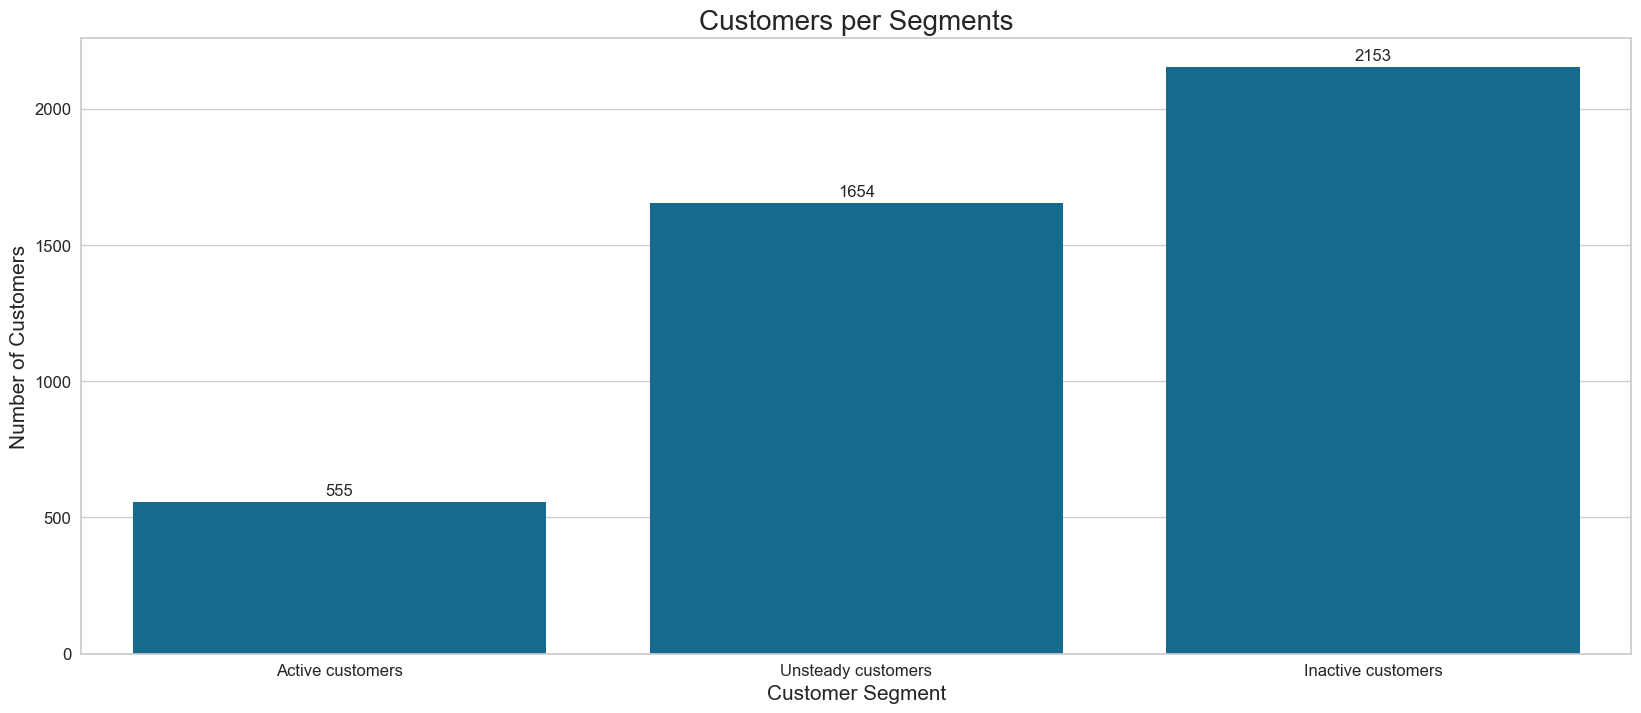

In [62]:
cust_segment = customer_segments_km.groupby(['customer_segment'])['CustomerID'].nunique()

plt.figure(figsize = [20, 8])
base_color = sns.color_palette()[0]
cat_order = ['Active customers', 'Unsteady customers', 'Inactive customers']

ax = sns.barplot(x = cust_segment.index, y = cust_segment.values, color = base_color, order = cat_order)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax.bar_label(ax.containers[0], padding = 3)

plt.title('Customers per Segments', size=20)
plt.xlabel('Customer Segment', size = 15)
plt.ylabel('Number of Customers', size = 15)

plt.show();

- The result of customer segmentation based on RFM metrics using percentile ranking is better than using Kmeans clustering. The segmentation using percentile ranking gives more insights and is more useful to understand each segment's unique needs and tailor the products and campaign strategies to meet those needs.